<a href="https://colab.research.google.com/github/ShubhamSongire/COVID-19-Chest-x-ray-challenge/blob/main/for_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load Kaggle dataset without downloading it using google colab**

In [1]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#import google.colab
from google.colab import files
files.upload

<function google.colab.files.upload>

In [5]:
!mkdir ~.\kaggle

In [9]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [10]:
!kaggle competitions download -c csc532

 97% 429M/441M [00:02<00:00, 209MB/s]
100% 441M/441M [00:02<00:00, 218MB/s]


In [11]:
!unzip /content/csc532.zip

Archive:  /content/csc532.zip
  inflating: DLAI3_CXR_Validation_Set/DLAI3_Val_Set1 (1).jpg  
  inflating: DLAI3_CXR_Validation_Set/DLAI3_Val_Set1 (10).jpg  
  inflating: DLAI3_CXR_Validation_Set/DLAI3_Val_Set1 (100).jpg  
  inflating: DLAI3_CXR_Validation_Set/DLAI3_Val_Set1 (101).jpg  
  inflating: DLAI3_CXR_Validation_Set/DLAI3_Val_Set1 (102).jpg  
  inflating: DLAI3_CXR_Validation_Set/DLAI3_Val_Set1 (103).jpg  
  inflating: DLAI3_CXR_Validation_Set/DLAI3_Val_Set1 (104).jpg  
  inflating: DLAI3_CXR_Validation_Set/DLAI3_Val_Set1 (105).jpg  
  inflating: DLAI3_CXR_Validation_Set/DLAI3_Val_Set1 (106).jpg  
  inflating: DLAI3_CXR_Validation_Set/DLAI3_Val_Set1 (107).jpg  
  inflating: DLAI3_CXR_Validation_Set/DLAI3_Val_Set1 (108).jpg  
  inflating: DLAI3_CXR_Validation_Set/DLAI3_Val_Set1 (109).jpg  
  inflating: DLAI3_CXR_Validation_Set/DLAI3_Val_Set1 (11).jpg  
  inflating: DLAI3_CXR_Validation_Set/DLAI3_Val_Set1 (110).jpg  
  inflating: DLAI3_CXR_Validation_Set/DLAI3_Val_Set1 (111).jpg  

# **Use Imagenet Inception_v3 to train our CNN model**

In [13]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [ ]:
IMAGE_SIZE = [224, 224]

train_path = '/content/datasets/datasets/train'
valid_path = '/content/datasets/datasets/test'

In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights
import tensorflow
resnet152V2 =tensorflow.keras.applications.ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

234561536/234545216 [==============================] - 2s 0us/step


In [ ]:
for layer in resnet152V2.layers:
    layer.trainable = False

In [ ]:
 # useful for getting number of output classes
folders = glob('/content/datasets/datasets/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(resnet152V2.output)

In [ ]:
#prediction = Dense(len(folders), activation='sigmoid')(x)
prediction = Dense(len(folders), activation='sigmoid')(x)

# create a model object
model = Model(inputs=resnet152V2.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# model.compile(
#   loss='binary_crossentropy',
#   optimizer='adam',
#   metrics=['accuracy']
# )
model.compile(
  loss=tensorflow.keras.losses.BinaryCrossentropy(),
  optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-3),
  metrics=[tensorflow.keras.metrics.BinaryAccuracy(),
                       tensorflow.keras.metrics.FalseNegatives()]
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/datasets/datasets/train',
                                                #  target_size = (224, 224),
                                                #  batch_size = 32,
                                                #  class_mode = 'binary')
                                                #  #class_mode = 'categorical') #binary
                                                 target_size = (224, 224),      # target image size
                                                 batch_size = 32,             # total images/batch size will show as epoch in 
                                                 )

Found 676 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/datasets/datasets/test',
                                            # target_size = (224, 224),
                                            # batch_size = 32,
                                            # class_mode = 'binary')
                                            # #class_mode = 'categorical')
                                             target_size = (224, 224),      # target image size
                                                 batch_size = 32,             # total images/batch size will show as epoch in 
                                                 )

Found 408 images belonging to 2 classes.


In [ ]:
test_set.class_indices

{'negative': 0, 'positive': 1}

In [ ]:
# fit the model
# Run the cell. It will take some time to execute
tensorflow.config.run_functions_eagerly(True)

r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


22/22 [==============================] - 46s 2s/step - loss: 1.6750 - binary_accuracy: 0.8572 - false_negatives: 90.0000 - val_loss: 3.2798 - val_binary_accuracy: 0.8480 - val_false_negatives: 49.0000
Epoch 2/20
22/22 [==============================] - 45s 2s/step - loss: 0.6031 - binary_accuracy: 0.9371 - false_negatives: 45.0000 - val_loss: 1.7599 - val_binary_accuracy: 0.9032 - val_false_negatives: 28.0000
Epoch 3/20
22/22 [==============================] - 43s 2s/step - loss: 0.3260 - binary_accuracy: 0.9527 - false_negatives: 36.0000 - val_loss: 1.5030 - val_binary_accuracy: 0.9203 - val_false_negatives: 28.0000
Epoch 4/20
22/22 [==============================] - 44s 2s/step - loss: 0.1826 - binary_accuracy: 0.9660 - false_negatives: 25.0000 - val_loss: 2.0966 - val_binary_accuracy: 0.8971 - val_false_negatives: 44.0000
Epoch 5/20
22/22 [==============================] - 43s 2s/step - loss: 0.1469 - binary_accuracy: 0.9726 - false_negatives: 20.0000 - val_loss: 3.0137 - val_binary

# **Save our trained model so next time no need to train model again and again**

In [ ]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/Colab Notebooks/Competative Programming/Kaggle/5 DL Covid19 Detection.ipynb/model_resnet152V2Binary.h5')

# **Loading our trained model to predict images**

In [17]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [18]:
model = load_model(r"/content/drive/MyDrive/Colab Notebooks/Competative Programming/Kaggle/5 DL Covid19 Detection.ipynb/model_resnet152V2Binary.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Patient is CoVID-19 Positive.


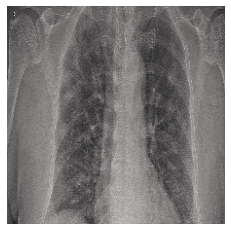

In [ ]:
import cv2
import matplotlib.pyplot as plt
img_size = 224
labels = ["Negative", "Positive"]
#image = input("Enter path of your image:- ")
#image = cv2.imread(r"%s"%image)
image = cv2.imread(r"/content/datasets/datasets/test/positive/1-s2.0-S0140673620303706-fx1_lrg.jpg")
image0 = cv2.resize(image, (224,224))
image = image0/255.0
image = image.reshape(-1, img_size, img_size, 3)
predict = model.predict(image)
predict = list(predict[0])
predict_name = labels[predict.index(max(predict))]
plt.imshow(image0)
plt.axis('off')
#cv2.waitKey()
#cv2.destroyAllWindows()
print("Patient is CoVID-19 %s."%predict_name)

In [25]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

lst1 = []
lst2 = []
for i in os.listdir("/content/DLAI3_CXR_Validation_Set"):
  #print(i)
  lst1.append(i)
  img_size = 224
  labels = ["Negative", "Positive"]
  image = cv2.imread(r"/content/DLAI3_CXR_Validation_Set/%s"%i)
  image0 = cv2.resize(image, (224,224))
  image = image0/255.0
  image = image.reshape(-1, img_size, img_size, 3)
  predict = np.argmax( model.predict(image))
  #print(predict)
  lst2.append(predict)

In [39]:
import pandas as pd
table = pd.DataFrame(list(zip(lst1, lst2)),columns=(['filename', 'label']))
table

,filename,label
0,DLAI3_Val_Set1 (132).jpg,0
1,DLAI3_Val_Set1 (84).jpg,0
2,DLAI3_Val_Set1 (136).jpg,0
3,DLAI3_Val_Set1 (17).jpg,0
4,DLAI3_Val_Set1 (27).jpg,0
...,...,...
245,DLAI3_Val_Set1 (29).jpg,0
246,DLAI3_Val_Set1 (99).jpg,0
247,DLAI3_Val_Set1 (184).jpg,0
248,DLAI3_Val_Set1 (231).jpg,0


In [40]:
table.to_csv("/content/drive/MyDrive/Colab Notebooks/Competative Programming/Kaggle/5 DL Covid19 Detection/Submission.csv", index=False)

In [55]:
!kaggle competitions submit -c csc532 -f /content/drive/MyDrive/Colab\ Notebooks/Competative\ Programming/Kaggle/5\ DL\ Covid19\ Detection/Submission.csv -m ""

100% 6.57k/6.57k [00:01<00:00, 5.81kB/s]
Successfully submitted to COVID-19 Chest x-ray challenge